# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler
import copy


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN


sns.set(font_scale=1.5)

2024-11-11 12:54:44.402670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 12:54:44.661784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 12:54:44.714853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 12:54:45.040689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 12:54:48.758230: W tensorflow/compiler/tf2

# Functions

In [2]:
def create_dataset(x, y, time_steps=1, pred_time_steps=1, overlap=True):
    xs, ys = [], []
    if overlap:
        jump = 1
    else:
        jump = pred_time_steps
    for i in range(0, len(x) - time_steps - pred_time_steps + 1, jump):
        v = x[i:(i + time_steps), :]
        xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + pred_time_steps])
    return np.array(xs), np.array(ys)

In [3]:
def make_RNN_model(input_shape, layers, dense_layers, activation, output, activation_out, rnn_layer='simple'):
    model = []
    ret_sequences = True
    if rnn_layer == 'lstm': 
        layer = LSTM(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)
    elif rnn_layer == 'gru':
        layer = GRU(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)
    else:
        layer = SimpleRNN(units=layers[0], return_sequences=ret_sequences, input_shape=input_shape)

    model.append(layer)
    
    for i in range(1, len(layers)):
        if i == len(layers)-1:
            ret_sequences = False
            
        if rnn_layer == 'lstm': 
            layer = LSTM(units=layers[i], return_sequences=ret_sequences)
        elif rnn_layer == 'gru':
            layer = GRU(units=layers[i], return_sequences=ret_sequences)
        else:
            layer = SimpleRNN(units=layers[i], return_sequences=ret_sequences)
        model.append(layer)

    for dl in dense_layers:
        model.append(tf.keras.layers.Dense(dl, activation=activation))

    model.append(tf.keras.layers.Dense(output, activation=activation_out))
    model = tf.keras.Sequential(model)

    return model

In [4]:
def train_RNN_network(train, test, val, layers, dense_layers, activation, output, activation_out, lags, epochs, batch_size, opt, loss, factor=0.8, patience_reduce=3, patience_early=5, rnn_layer='simple'):
    dict_results = {'Lags': [], 'MAE': [], 'RMSE': [], 'R2': []}
    for i in lags:
        x_train, y_train = create_dataset(train, train, i, output, True)
        x_val, y_val = create_dataset(val, val, i, output, False)
        x_test, y_test = create_dataset(test, test, i, output, False)

        model = make_RNN_model((i,1), layers, dense_layers, activation, output, activation_out, rnn_layer)

        opt_tmp = copy.copy(opt)
        model_tmp = tf.keras.models.clone_model(model)
        model_tmp.compile(optimizer=opt_tmp, loss=loss, metrics=['mae', 'mse'])
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=factor, patience=patience_reduce)
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early, restore_best_weights=True)
        history = model_tmp.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[reduce_lr, early_stopping])

        y_pred = model_tmp.predict(x_test, verbose=0, batch_size=batch_size)
        y_pred = scaler.inverse_transform(y_pred).flatten()
        y_test = scaler.inverse_transform(y_test[:,:,0]).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        dict_results['MAE'].append(mae)
        dict_results['RMSE'].append(rmse)
        dict_results['R2'].append(r2)
        dict_results['Lags'].append(i)

        print('MAE:', mae, 'RMSE:', rmse, 'and R2:', r2, 'for', i, 'lags')
    return pd.DataFrame(dict_results)

# About Dataset
This dataset is the most up-to-date kaggle dataset about daily sunspot counts with no missing values. The source data originate from the World Data Center SILSO, Royal Observatory of Belgium, Brussels.

The Daily total sunspot number is derived by the formula: R = Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk. The original data contained some values between 1818 and 1850 but I removed those years because there was too much missing values.


**Error values**

Those values correspond to the standard deviation of raw numbers provided by all stations.

* Before 1981, the errors are estimated with the help of an auto-regressive model based on the Poissonian distribution of actual Sunspot Numbers.
* From 1981 onwards, the error value is the actual standard deviation of the sample of raw observations used to compute the daily value.

**The standard error of the daily Sunspot Number can be computed by:**

sigma/sqrt(N) where sigma is the listed standard deviation and N the number of observations for the day.
Before 1981, the number of observations is set to 1, as the Sunspot Number was then essentially the raw Wolf number from the Zürich Observatory.


**Columns Description**

* Column 1-3: Gregorian calendar date
    * Year
    * Month
    * Day
* Column 4: Date in fraction of year
*  Column 5: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value): there should not be any missing values as I removed all years before 1850 where there was missing values.
* Column 6: Daily standard deviation of the input sunspot numbers from individual stations.
* Column 7: Number of observations used to compute the daily value.
* Column 8: Definitive/provisional indicator. A blank (NaN) indicates that the value is definitive. A '*' symbol indicates that the value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

# Preprocessing data

## Read data

In [5]:
df = pd.read_csv('sunspots_1850_2024.csv')
df.head()

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN


## Make dataset

In [6]:
df = pd.DataFrame(df.groupby(pd.PeriodIndex(df['date'], freq="D"))['counts'].mean())
df = df.reset_index()
df['date'] = df['date'].dt.to_timestamp('s').dt.strftime(r'%Y-%m-%d')
df = df.set_index('date')
df.head()

,counts
date,
1850-01-01,253.0
1850-01-02,162.0
1850-01-03,217.0
1850-01-04,99.0
1850-01-05,108.0


# Exploratory Analysis

## Plot sunspots monthly mean by time

(array([    0,  1460,  2920,  4380,  5840,  7300,  8760, 10220, 11680,
        13140, 14600, 16060, 17520, 18980, 20440, 21900, 23360, 24820,
        26280, 27740, 29200, 30660, 32120, 33580, 35040, 36500, 37960,
        39420, 40880, 42340, 43800, 45260, 46720, 48180, 49640, 51100,
        52560, 54020, 55480, 56940, 58400, 59860, 61320, 62780]),
 [Text(0, 0, '1850-01-01'),
  Text(1460, 0, '1853-12-31'),
  Text(2920, 0, '1857-12-30'),
  Text(4380, 0, '1861-12-29'),
  Text(5840, 0, '1865-12-28'),
  Text(7300, 0, '1869-12-27'),
  Text(8760, 0, '1873-12-26'),
  Text(10220, 0, '1877-12-25'),
  Text(11680, 0, '1881-12-24'),
  Text(13140, 0, '1885-12-23'),
  Text(14600, 0, '1889-12-22'),
  Text(16060, 0, '1893-12-21'),
  Text(17520, 0, '1897-12-20'),
  Text(18980, 0, '1901-12-20'),
  Text(20440, 0, '1905-12-19'),
  Text(21900, 0, '1909-12-18'),
  Text(23360, 0, '1913-12-17'),
  Text(24820, 0, '1917-12-16'),
  Text(26280, 0, '1921-12-15'),
  Text(27740, 0, '1925-12-14'),
  Text(29200, 0, '19

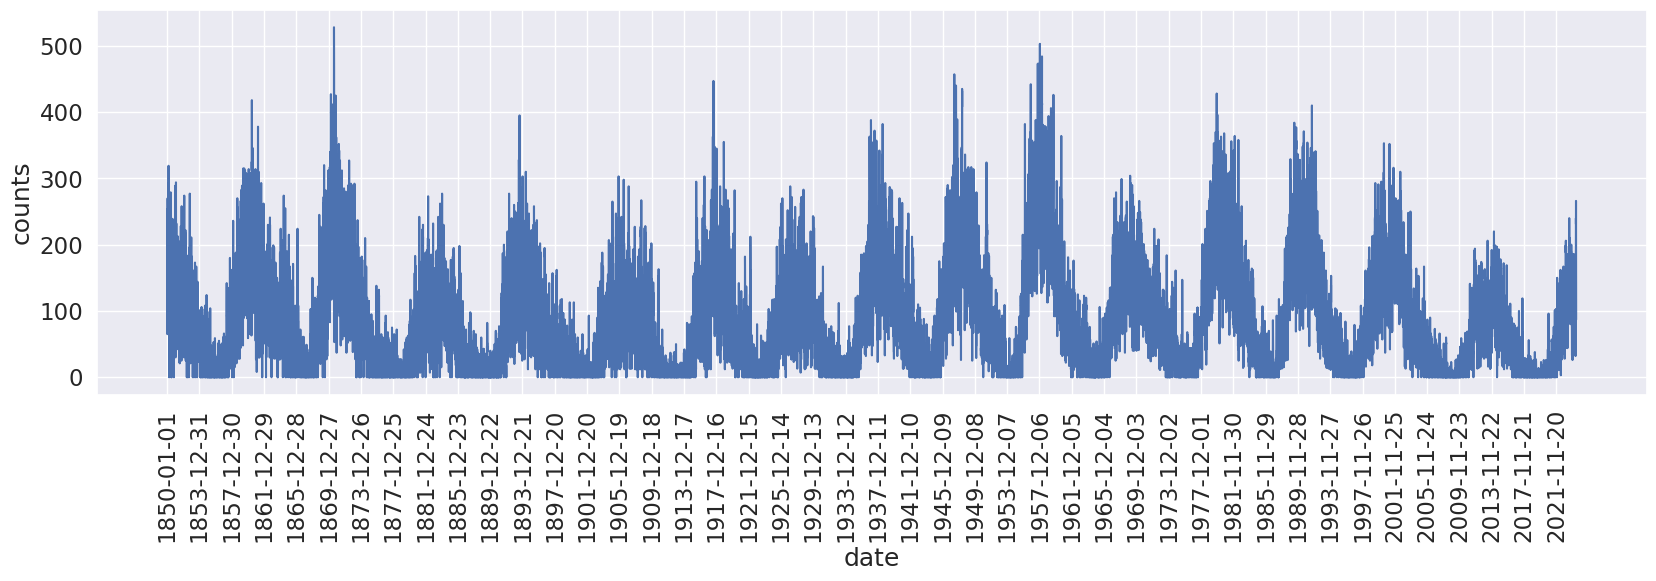

In [7]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(y=df['counts'], x=df.index)
ax.set_xticks(ax.get_xticks()[::1460])
plt.xticks(rotation=90)

In [8]:
df.describe()

,counts
count,63673.000000
mean,83.410174
std,76.875804
min,0.000000
25%,21.000000
50%,64.000000
75%,128.000000
max,528.000000


# Prepare data

## Scale data

In [9]:
scaler  = MinMaxScaler() # scaler
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled = df_scaled.rename(columns = {0: 'value'})
df_scaled.head()

,value
0,0.479167
1,0.306818
2,0.410985
3,0.187500
4,0.204545


## Split data

In [10]:
train_split = int(len(df) * 0.7)
val_split = int(len(df) * 0.1)

In [11]:
df_train = df_scaled[:train_split].to_numpy()
df_val = df_scaled[train_split:train_split+val_split].to_numpy()
df_test = df_scaled[train_split+val_split:].to_numpy()

# Train RNN

## Simple RNN

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='simple')

/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 23.058574657788277 RMSE: 32.84256707970362 and R2: 0.7886098211555901 for 7 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 32.8984182164189 RMSE: 41.308314131966036 and R2: 0.6644328828616675 for 15 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 56.675769365439024 RMSE: 67.92216282373481 and R2: 0.09200865255784096 for 30 lags


<Axes: xlabel='Lags', ylabel='RMSE'>

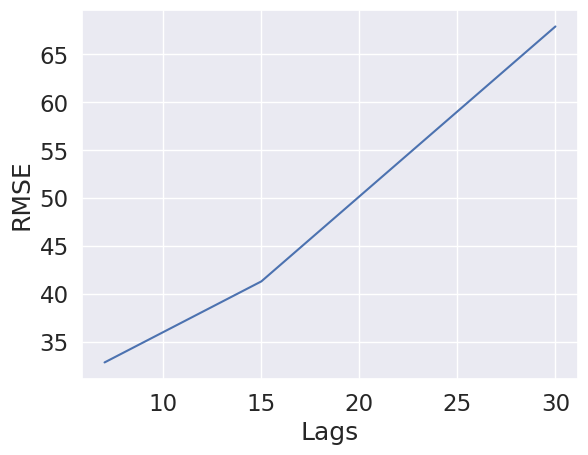

In [19]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

## GRU

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30,60,120,365], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='gru')

/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 22.84609125230216 RMSE: 32.77699315258951 and R2: 0.7894531076094577 for 7 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 20.95711840596511 RMSE: 30.59266190908594 and R2: 0.815948657633629 for 15 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.781007686800397 RMSE: 28.640116181200852 and R2: 0.8385610784638137 for 30 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MAE: 19.898394114028402 RMSE: 28.757482586926063 and R2: 0.8352893956840306 for 60 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-11 13:20:22.769562: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-11-11 13:20:22.780259: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-11-11 13:20:24.120794: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-11-11 13:20:24.961137: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exceeds 10% of free system memory.
2024-11-11 13:20:24.978350: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31457280 exce

MAE: 19.372732584234914 RMSE: 27.93154600380414 and R2: 0.8415739668852797 for 120 lags


/home/eber/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Axes: xlabel='Lags', ylabel='RMSE'>

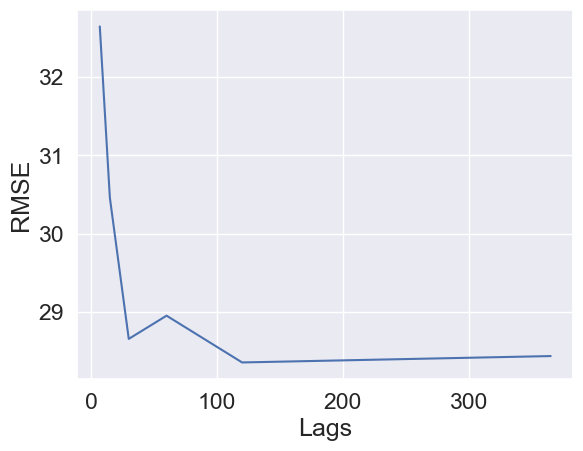

In [ ]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

## LSTM

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
scores = train_RNN_network(train=df_train, test=df_test, val=df_val, layers=[64,64], dense_layers=[32],
                           activation='relu', output=7, activation_out=None, lags=[7,15,30,60,120,365], epochs=30, batch_size=1024, opt=opt,
                           loss='mse', rnn_layer='lstm')

MAE: 23.270184622598897 RMSE: 33.12330651065434 and R2: 0.7849804335778965 for 7 lags
MAE: 20.83502931216292 RMSE: 30.35866767837108 and R2: 0.8187533987967752 for 15 lags
MAE: 20.356018381454682 RMSE: 28.94023139761609 and R2: 0.835159965986876 for 30 lags
MAE: 19.928380134248656 RMSE: 29.476221720673344 and R2: 0.8269532453439087 for 60 lags
MAE: 19.750444291025136 RMSE: 28.489278872000686 and R2: 0.8351839461229765 for 120 lags
MAE: 20.481151437919205 RMSE: 29.141307827200762 and R2: 0.8173958433479434 for 365 lags


<Axes: xlabel='Lags', ylabel='RMSE'>

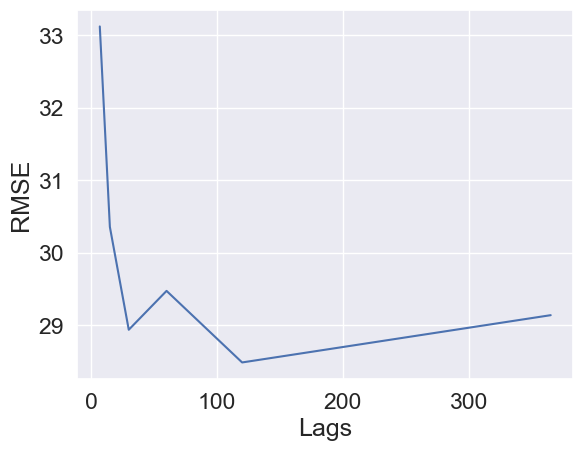

In [ ]:
sns.lineplot(data=scores, x='Lags', y='RMSE')

# Select one model

In [ ]:
time_steps = 120
pred_time_steps = 7
x_train, y_train = create_dataset(df_train, df_train, time_steps, pred_time_steps, True)
x_val, y_val = create_dataset(df_val, df_val, time_steps, pred_time_steps, True)
x_test, y_test = create_dataset(df_test, df_test, time_steps, pred_time_steps, False)

In [ ]:
model = make_RNN_model(input_shape=(time_steps, 1), layers=[64,64], dense_layers=[32], activation='relu',
                       output=pred_time_steps, activation_out=None, rnn_layer='gru')
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=300, batch_size=1024, verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/300
44/44 [==============================] - 3s 38ms/step - loss: 0.0139 - mae: 0.0814 - mse: 0.0139 - val_loss: 0.0054 - val_mae: 0.0540 - val_mse: 0.0054 - lr: 0.0100
Epoch 2/300
44/44 [==============================] - 1s 27ms/step - loss: 0.0056 - mae: 0.0533 - mse: 0.0056 - val_loss: 0.0052 - val_mae: 0.0541 - val_mse: 0.0052 - lr: 0.0100
Epoch 3/300
44/44 [==============================] - 1s 27ms/step - loss: 0.0051 - mae: 0.0511 - mse: 0.0051 - val_loss: 0.0041 - val_mae: 0.0449 - val_mse: 0.0041 - lr: 0.0100
Epoch 4/300
44/44 [==============================] - 1s 27ms/step - loss: 0.0047 - mae: 0.0488 - mse: 0.0047 - val_loss: 0.0042 - val_mae: 0.0448 - val_mse: 0.0042 - lr: 0.0100
Epoch 5/300
44/44 [==============================] - 1s 27ms/step - loss: 0.0047 - mae: 0.0485 - mse: 0.0047 - val_loss: 0.0040 - val_mae: 0.0442 - val_mse: 0.0040 - lr: 0.0100
Epoch 6/300
44/44 [==============================] - 1s 26ms/step - loss: 0.0048 - mae: 0.0489 - mse: 0.0048 - val_

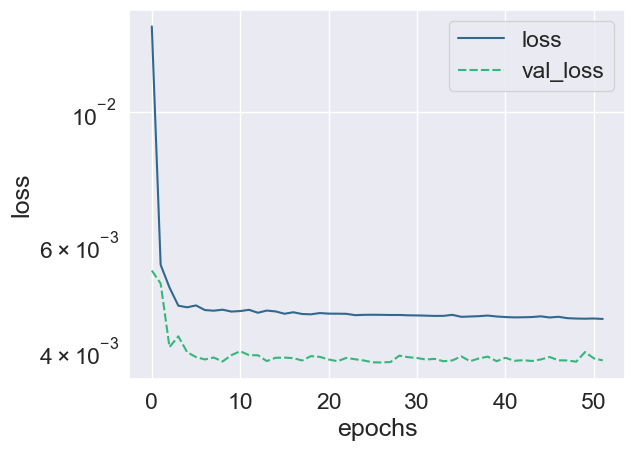

In [ ]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

## Test results

In [ ]:
y_pred = scaler.inverse_transform(model.predict(x_test)).flatten()
y_true = scaler.inverse_transform(y_test[:,:, 0]).flatten()

57/57 [==============================] - 1s 7ms/step


MAE: 19.474465455814418 
RMSE: 27.930107678020818 
R2: 0.841590282658216


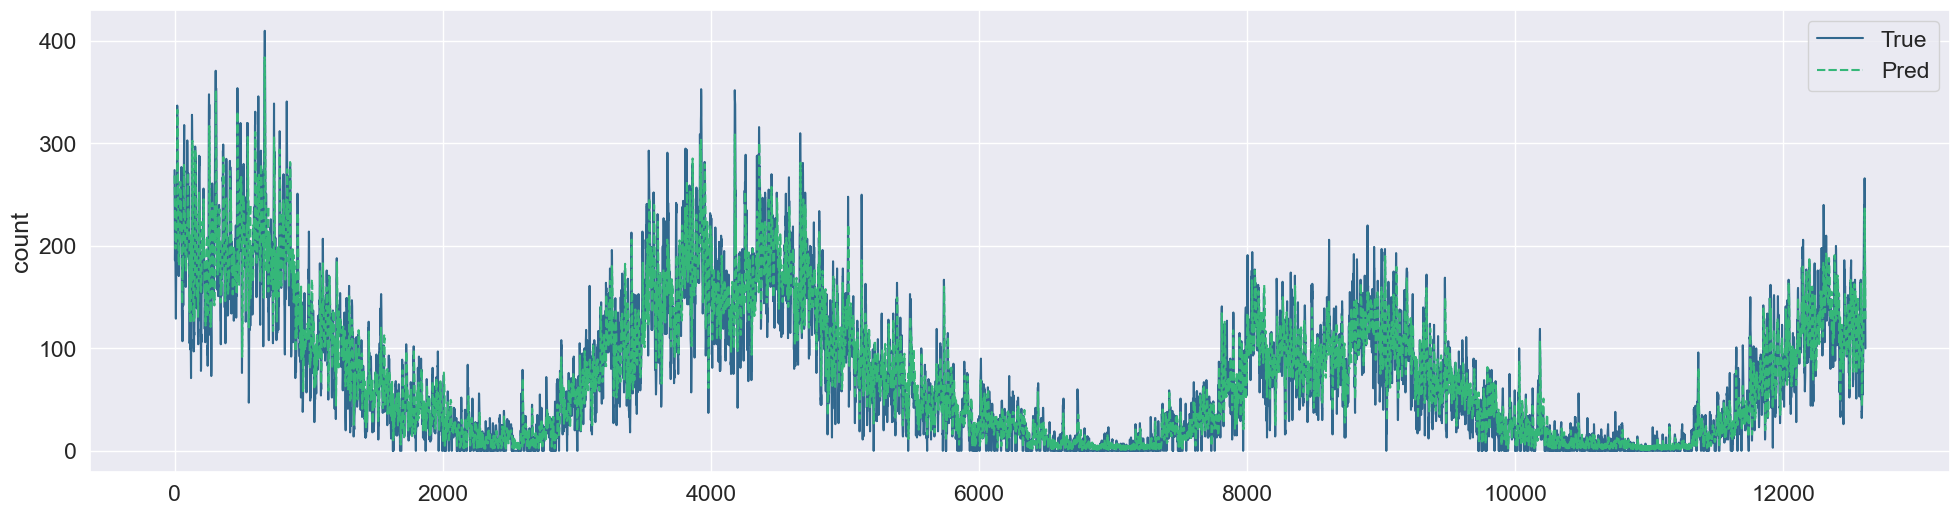

In [ ]:
plt.figure(figsize=(24,6))
res = {'True': y_true, 'Pred': y_pred}
sns.lineplot(data=res, palette='viridis')
plt.ylabel('count')
print('MAE:', mean_absolute_error(y_true, y_pred), '\nRMSE:', np.sqrt(mean_squared_error(y_true, y_pred)), '\nR2:', r2_score(y_true, y_pred))